<a href="https://colab.research.google.com/github/HanifFaishalH/Kuis2_KlasifikasiJenisBatik/blob/main/Kuis2_Batik_Fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Preprocessing Data Batik

augmentasi data > 1 gambar menjadi 4 gambar (1 gambar asli + 3 gambar hasil augmentasi)
Image enhancement → contras/brightness correction, noise removal, glare removal, etc.

In [ ]:
!pip install albumentations==1.3.1 opencv-python tqdm

import cv2
import numpy as np
import albumentations as A
from pathlib import Path
from google.colab import files
from tqdm import tqdm

input_folder = ('/content/drive/MyDrive/batik_dataset/Batik300')
output_folder = ('/content/drive/MyDrive/batik_dataset/batik_aug')
copies_per_image = 3
img_size = 512

Path(output_folder).mkdir(parents=True, exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.7),
    A.Rotate(limit=30, p=0.5),
])

image_files = sorted([
    p for p in Path(input_folder).glob("*")
    if p.suffix.lower() in [".jpg", ".jpeg", ".png"]
])

print(f"Total gambar batik-cap ditemukan: {len(image_files)}")
print(f"Memulai augmentasi (Total output: {len(image_files) * (copies_per_image + 1)} gambar)...")

for img_path in tqdm(image_files, desc="Augmentasi Gambar"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Gagal membaca: {img_path.name}, skipping.")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    base_name = img_path.stem

    original_resized = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    save_path_original = Path(output_folder) / f"{base_name}_original.jpg"
    cv2.imwrite(str(save_path_original), cv2.cvtColor(original_resized, cv2.COLOR_RGB2BGR))

    for i in range(copies_per_image):
        aug = transform(image=img)
        aug_img = aug["image"]

        if aug_img.dtype != np.uint8:
            aug_img = np.clip(aug_img, 0, 255).astype(np.uint8)

        aug_img = cv2.resize(aug_img, (img_size, img_size), interpolation=cv2.INTER_AREA)

        save_path = Path(output_folder) / f"{base_name}_aug_{i+1:02d}.jpg"
        cv2.imwrite(str(save_path), cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

print("\nSelesai! Semua gambar batik-cap berhasil di-augment.")
print(f"Total gambar di folder output: {len(list(Path(output_folder).glob('*.jpg')))}")

Total gambar batik-cap ditemukan: 300
Memulai augmentasi (Total output: 1200 gambar)...


Augmentasi Gambar: 100%|██████████| 300/300 [00:23<00:00, 12.59it/s]


Selesai! Semua gambar batik-cap berhasil di-augment.
Total gambar di folder output: 1200


Melakukan enhancement gambar...


100%|██████████| 1200/1200 [02:29<00:00,  8.03it/s]


Enhancement selesai! Hasil disimpan di: /content/drive/MyDrive/batik_dataset/batik-enhanced


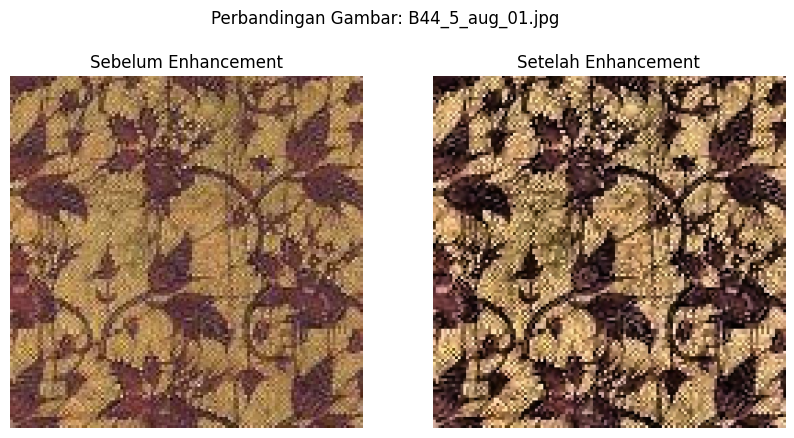

In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import random
from matplotlib import pyplot as plt

input_dir = '/content/drive/MyDrive/batik_dataset/batik_aug'
output_dir = '/content/drive/MyDrive/batik_dataset/batik-enhanced'
os.makedirs(output_dir, exist_ok=True)

def enhance_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    # 1. Contrast enhancement (CLAHE)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # 2. Brightness normalization
    hsv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.equalizeHist(v)
    hsv_enhanced = cv2.merge((h, s, v))
    enhanced = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)

    # 3. Noise removal (bilateral)
    denoised = cv2.bilateralFilter(enhanced, d=9, sigmaColor=75, sigmaSpace=75)

    # 4. Glare removal
    gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    glare_removed = cv2.inpaint(denoised, mask, 3, cv2.INPAINT_TELEA)

    return glare_removed

print("Melakukan enhancement gambar...")
for filename in tqdm(os.listdir(input_dir)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        enhanced = enhance_image(input_path)
        if enhanced is not None:
            cv2.imwrite(output_path, enhanced)
print("Enhancement selesai! Hasil disimpan di:", output_dir)

random_file = random.choice([f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
before_path = os.path.join(input_dir, random_file)
after_path = os.path.join(output_dir, random_file)

before = cv2.imread(before_path)
after = cv2.imread(after_path)

# Ubah BGR ke RGB agar warna tampil benar di matplotlib
before = cv2.cvtColor(before, cv2.COLOR_BGR2RGB)
after = cv2.cvtColor(after, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(before)
plt.title("Sebelum Enhancement")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(after)
plt.title("Setelah Enhancement")
plt.axis("off")

plt.suptitle(f"Perbandingan Gambar: {random_file}")
plt.show()

# 2. Ekstraksi Fitur

Metode ekstraksi fitur yang digunakan terdiri dari tiga jenis, yaitu GLCM, LBP, dan HSV Histogram. Fitur ini diekstraksi dari setiap gambar batik untuk membedakan motif batik (misal parang, kawung, mega mendung, dsb.):

GLCM (Gray Level Co-occurrence Matrix) – menangkap tekstur motif, seperti rapat atau halus, melalui fitur contrast, dissimilarity, homogeneity, energy, correlation.

LBP (Local Binary Pattern) – menangkap pola lokal pada motif, misal garis, titik, atau pola berulang, menggunakan mean dan std histogram LBP.

HSV Histogram – menangkap ciri warna motif, seperti dominasi warna atau gradasi khas motif batik.

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern

# === Path input dan output ===
input_dir = '/content/drive/MyDrive/batik_dataset/batik-enhanced'  # folder hasil enhancement
label_csv = '/content/drive/MyDrive/batik_dataset/motif_batik_label.csv'
output_csv = '/content/drive/MyDrive/batik_dataset/batik_motif_features.csv'

# === Fungsi ekstraksi fitur citra ===
def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # --- GLCM ---
    glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()

    # --- LBP ---
    lbp = local_binary_pattern(gray, 8, 1, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 59))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    lbp_mean = hist.mean()
    lbp_std = hist.std()

    # --- HSV ---
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [8], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [8], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [8], [0, 256])
    color_features = np.concatenate([hist_h, hist_s, hist_v]).flatten()
    color_features /= (color_features.sum() + 1e-7)

    return np.hstack([
        [contrast, dissimilarity, homogeneity, energy, correlation],
        [lbp_mean, lbp_std],
        color_features
    ])

# Ekstraksi fitur dari semua gambar
data = []
filenames = []

print("Mengekstraksi fitur dari semua citra di folder...")
for file in tqdm(os.listdir(input_dir)):
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(input_dir, file)
        feats = extract_features(img_path)
        if feats is not None:
            data.append(feats)
            filenames.append(file)

if len(data) == 0:
    print("Tidak ada citra valid di folder ini! Pastikan input_dir sudah benar.")
else:
    columns = [
        'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation',
        'lbp_mean', 'lbp_std'
    ] + [f'color_{i+1}' for i in range(24)]

    features_df = pd.DataFrame(data, columns=columns)
    features_df['filename'] = filenames

    labels_df = pd.read_csv(label_csv)

    def normalize_filename(name):
        """
        Normalisasi nama file dengan mengekstrak hanya ID Kelas utamanya.
        Contoh:
        - 'B10_2_original.jpg'  -> 'B10'
        - 'B10_1.jpg'           -> 'B10'
        - 'B23_1.jpg'           -> 'B23'
        """
        match = re.match(r'(B\d+)', name, flags=re.IGNORECASE)
        if match:
            return match.group(1)
        return name

    features_df['base_name'] = features_df['filename'].apply(normalize_filename)
    labels_df['base_name'] = labels_df['filename'].apply(normalize_filename)

    print("\n Contoh nama setelah normalisasi:")
    print("Fitur :", features_df['base_name'].unique()[:5])
    print("Label :", labels_df['base_name'].unique()[:5])

    merged_df = features_df.merge(labels_df[['base_name', 'motif_batik']],
                                  on='base_name', how='left')
    merged_df.rename(columns={'motif_batik': 'motif_name'}, inplace=True)
    merged_df.drop(columns=['base_name'], inplace=True)

    missing_before = merged_df['motif_name'].isna().sum()
    print(f"\n Ada {missing_before} citra tanpa motif_name sebelum perbaikan.")

    def fill_label_safe(row):
        if pd.notna(row['motif_name']):
            return row['motif_name']

        fname = row['filename']
        m = re.match(r'(B\d+_\d+)', fname)
        if not m:
            return np.nan
        key = m.group(1)

        for method, func in [
            ('exact', labels_df['base_name'] == key),
            ('startswith', labels_df['base_name'].str.startswith(key, na=False)),
            ('contains', labels_df['base_name'].str.contains(key, case=False, na=False))
        ]:
            cand = labels_df.loc[func, 'motif_batik']
            if not cand.empty:
                return cand.iloc[0]

        return np.nan

    merged_df['motif_name'] = merged_df.apply(fill_label_safe, axis=1)

    missing_after = merged_df['motif_name'].isna().sum()
    print(f" Label berhasil diisi. Sebelum: {missing_before} | Sekarang: {missing_after}")

    if missing_after > 0:
        print("\nContoh file tanpa label (cek manual):")
        display(merged_df[merged_df['motif_name'].isna()][['filename']].head(10))

    merged_df.to_csv(output_csv, index=False)
    print(f"\n Ekstraksi dan labeling selesai!")
    print(f" File disimpan di: {output_csv}")
    print(f" Total citra: {len(merged_df)} | Tanpa label: {missing_after}")

    display(merged_df[['filename', 'motif_name']].head(10))


Mengekstraksi fitur dari semua citra di folder...


100%|██████████| 1200/1200 [03:44<00:00,  5.34it/s]



 Contoh nama setelah normalisasi:
Fitur : ['B10' 'B11' 'B12' 'B13' 'B14']
Label : ['B1' 'B2' 'B3' 'B4' 'B5']

 Ada 0 citra tanpa motif_name sebelum perbaikan.
 Label berhasil diisi. Sebelum: 0 | Sekarang: 0

 Ekstraksi dan labeling selesai!
 File disimpan di: /content/drive/MyDrive/batik_dataset/batik_motif_features.csv
 Total citra: 1200 | Tanpa label: 0


,filename,motif_name
0,B10_1_original.jpg,Mega Mendung
1,B10_1_aug_01.jpg,Mega Mendung
2,B10_1_aug_02.jpg,Mega Mendung
3,B10_1_aug_03.jpg,Mega Mendung
4,B10_2_original.jpg,Mega Mendung
5,B10_2_aug_01.jpg,Mega Mendung
6,B10_2_aug_02.jpg,Mega Mendung
7,B10_2_aug_03.jpg,Mega Mendung
8,B10_3_original.jpg,Mega Mendung
9,B10_3_aug_01.jpg,Mega Mendung


3. Pembuatan data latih dan data uji
    - Melakukan metode split,
        - 70:30
        - 80:20
        - 90:10
        - Cross-validation dengan k=5

Train-Test Split


=== Hasil Train-Test Split ===
   Split  Train Size  Test Size  SVM_linear  SVM_poly   SVM_rbf  KNN (k=5)  \
0  70:30         840        360    1.000000  0.722222  0.994444   0.997222   
1  80:20         960        240    0.995833  0.708333  0.983333   0.983333   
2  90:10        1080        120    1.000000  0.766667  0.991667   1.000000   

   Naive Bayes  
0     0.941667  
1     0.925000  
2     0.975000  

=== Hasil K-Fold Cross Validation ===
         Model  Mean Accuracy   Std Dev
0   SVM_linear       0.999167  0.001667
1     SVM_poly       0.738333  0.018333
2      SVM_rbf       0.988333  0.007638
3    KNN (k=5)       0.989167  0.006770
4  Naive Bayes       0.937500  0.011487


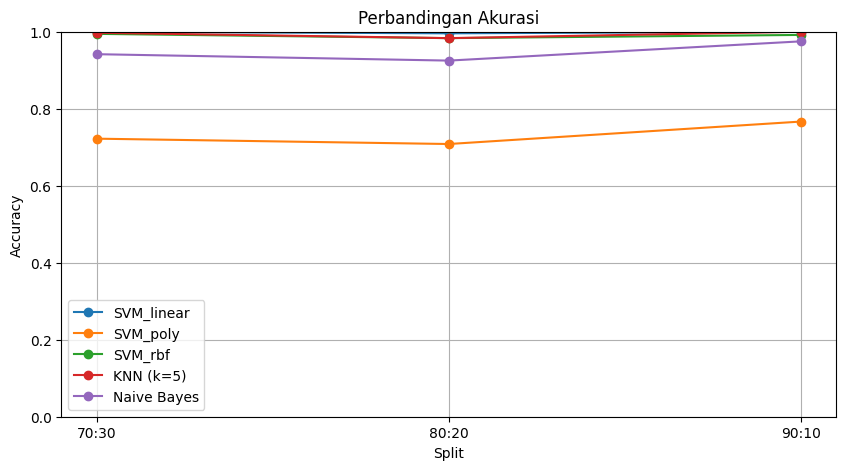

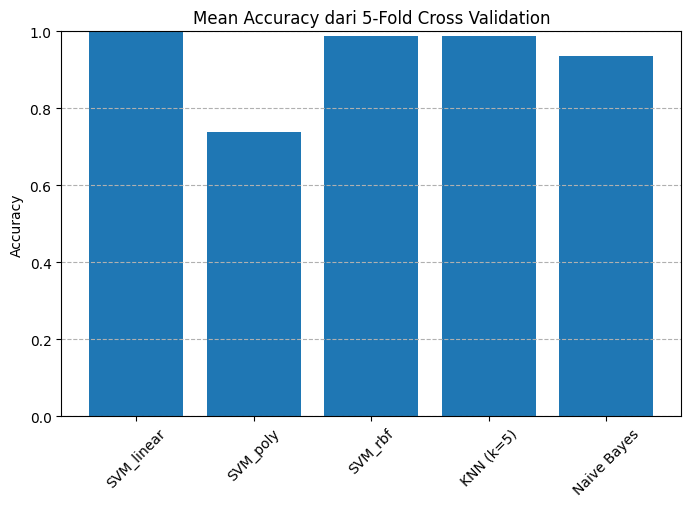

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/drive/MyDrive/batik_dataset/batik_motif_features.csv')

X = df.drop(columns=['filename','motif_name'], errors='ignore').values
y = df['motif_name'].values

models = {
    "SVM_linear": SVC(kernel='linear'),
    "SVM_poly": SVC(kernel='poly'),
    "SVM_rbf": SVC(kernel='rbf'),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

ratios = [0.3, 0.2, 0.1]
ratio_names = ["70:30", "80:20", "90:10"]

results = []
conf_matrices = {}
class_reports = {}


for ratio, split_name in zip(ratios, ratio_names):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=ratio, random_state=42, stratify=y
    )

    train_size = len(X_train)
    test_size = len(X_test)
    row = [split_name, train_size, test_size]

    for name, model in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95)),
            ('clf', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        row.append(accuracy_score(y_test, y_pred))

        conf_matrices[(split_name, name)] = confusion_matrix(y_test, y_pred)
        class_reports[(split_name, name)] = classification_report(
            y_test, y_pred, zero_division=0
        )

    results.append(row)

res_df = pd.DataFrame(
    results,
    columns=["Split", "Train Size", "Test Size"] + list(models.keys())
)

print("\n=== Hasil Train-Test Split ===")
print(res_df)


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('clf', model)
    ])

    scores = cross_val_score(pipeline, X, y, cv=skf)
    cv_results.append([name, scores.mean(), scores.std()])

cv_df = pd.DataFrame(
    cv_results,
    columns=["Model", "Mean Accuracy", "Std Dev"]
)

print("\n=== Hasil K-Fold Cross Validation ===")
print(cv_df)

plt.figure(figsize=(10,5))
for model_name in models.keys():
    plt.plot(res_df["Split"], res_df[model_name], marker='o', label=model_name)
plt.title("Perbandingan Akurasi")
plt.xlabel("Split")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.bar(cv_df["Model"], cv_df["Mean Accuracy"])
plt.title("Mean Accuracy dari 5-Fold Cross Validation")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--')
plt.show()


## Visualisasi dengan PCA


Rasio variansi:
PC1: 21.74%
PC2: 17.05%


/tmp/ipython-input-564416336.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


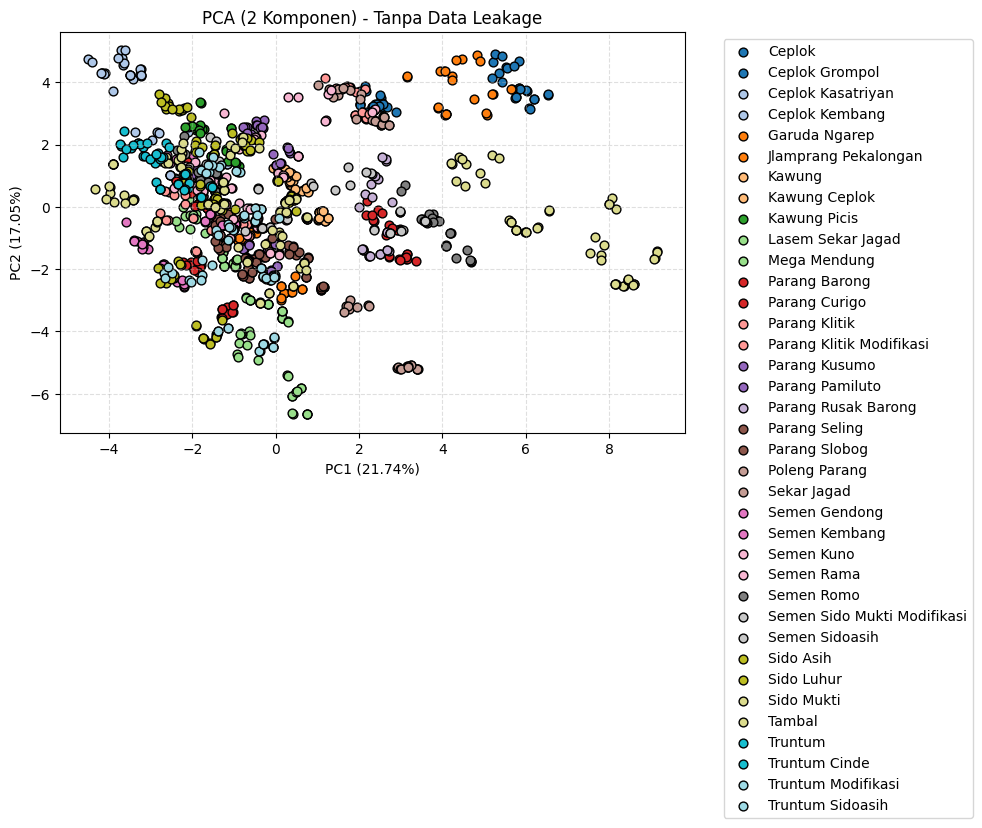

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/batik_dataset/batik_motif_features.csv')

non_feature_cols = ['filename', 'motif_name']
X = df.drop(columns=non_feature_cols, errors='ignore').values
y = df['motif_name'].values

# Split dulu
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling fit pada train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# PCA fit hanya pada train
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# Gabungkan kembali untuk plot
X_pca_all = np.vstack([X_train_pca, X_test_pca])
y_all = np.concatenate([y_train, y_test])

# Plot
plt.figure(figsize=(10,7))
unique_labels = sorted(np.unique(y_all))
colors = plt.cm.get_cmap('tab20', len(unique_labels))

for i, label in enumerate(unique_labels):
    mask = (y_all == label)
    plt.scatter(X_pca_all[mask, 0], X_pca_all[mask, 1],
                label=label, s=40, edgecolor='black', alpha=0.7)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()


# 4. Pembuatan model
    - Model yang digunakan bebas, *kecuali jenis deep learning*
    - Melakukan proses hyperparameter tunning menjadi nilai tambah
    - Simpan model dalam bentuk file


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

csv_path = '/content/drive/MyDrive/batik_dataset/batik_motif_features.csv'
df = pd.read_csv(csv_path)

print("Data tersedia:", df.shape)
print(df[['motif_name']].head())

X = df[[c for c in df.columns if c.startswith(('contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'lbp_', 'color_'))]]
y = df['motif_name']

# Encode label jadi angka
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

print("Melakukan GridSearchCV...")
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=3, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

y_pred = grid.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"\n Akurasi di data test: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

model_path = '/content/drive/MyDrive/batik_dataset/svm_batik_model.joblib'
scaler_path = '/content/drive/MyDrive/batik_dataset/scaler.joblib'
label_path = '/content/drive/MyDrive/batik_dataset/label_encoder.joblib'

joblib.dump(grid.best_estimator_, model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(le, label_path)

print(f"Model disimpan ke: {model_path}")
print(f"Scaler disimpan ke: {scaler_path}")
print(f"Label Encoder disimpan ke: {label_path}")

Data tersedia: (1200, 33)
     motif_name
0  Mega Mendung
1  Mega Mendung
2  Mega Mendung
3  Mega Mendung
4  Mega Mendung
Melakukan GridSearchCV...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Score: 0.9958333333333332

 Akurasi di data test: 0.9958

Classification Report:
                             precision    recall  f1-score   support

                     Ceplok       1.00      1.00      1.00         5
             Ceplok Grompol       1.00      1.00      1.00         5
          Ceplok Kasatriyan       1.00      1.00      1.00         5
             Ceplok Kembang       1.00      1.00      1.00         5
              Garuda Ngarep       1.00      1.00      1.00         5
       Jlamprang Pekalongan       1.00      1.00      1.00         5
                     Kawung       1.00      1.00      1.00         5
              Kawung Ceplok       1.00      1.00      1.00         5
               Kawu

In [ ]:
import joblib

svm_model = joblib.load('/content/drive/MyDrive/batik_dataset/svm_batik_model.joblib')
print("=== SVM Model ===")
print(svm_model)
print("\n")

label_encoder = joblib.load('/content/drive/MyDrive/batik_dataset/label_encoder.joblib')
print("=== Label Encoder ===")
print(label_encoder)
print("\nDaftar kelas label_encoder.classes_:")
print(label_encoder.classes_)
print("\n")

scaler = joblib.load('/content/drive/MyDrive/batik_dataset/scaler.joblib')
print("=== Scaler (StandardScaler) ===")
print(scaler)

print("\nNilai mean scaler (scaler.mean_):")
print(scaler.mean_)

print("\nNilai scale standar (scaler.scale_):")
print(scaler.scale_)

=== SVM Model ===
SVC(C=10)


=== Label Encoder ===
LabelEncoder()

Daftar kelas label_encoder.classes_:
['Ceplok' 'Ceplok Grompol' 'Ceplok Kasatriyan' 'Ceplok Kembang'
 'Garuda Ngarep' 'Jlamprang Pekalongan' 'Kawung' 'Kawung Ceplok'
 'Kawung Picis' 'Lasem Sekar Jagad' 'Mega Mendung' 'Parang Barong'
 'Parang Curigo' 'Parang Klitik' 'Parang Klitik Modifikasi'
 'Parang Kusumo' 'Parang Pamiluto' 'Parang Rusak Barong' 'Parang Seling'
 'Parang Slobog' 'Poleng Parang' 'Sekar Jagad' 'Semen Gendong'
 'Semen Kembang' 'Semen Kuno' 'Semen Rama' 'Semen Romo'
 'Semen Sido Mukti Modifikasi' 'Semen Sidoasih' 'Sido Asih' 'Sido Luhur'
 'Sido Mukti' 'Tambal' 'Truntum' 'Truntum Cinde' 'Truntum Modifikasi'
 'Truntum Sidoasih']


=== Scaler (StandardScaler) ===
StandardScaler()

Nilai mean scaler (scaler.mean_):
[1.00020677e+03 1.38299201e+01 2.43222821e-01 1.63394750e-02
 8.75226288e-01 1.72413793e-02 4.66546609e-02 2.81646052e-01
 2.41144591e-02 2.54037248e-03 5.76770306e-04 2.03928020e-03
 1.84888574e-0

# Langkah 5 Evaluasi model
    - Evaluasi performa model berdasarkan data training dan testing melalui metriks
        
        - Akurasi
        
        - Presisi
        
        - Recall
        
        - F1-Score
    
    - Sajikan hasil performansi model menggunakan grafik

Mengevaluasi model terbaik (SVM RBF) pada data Training dan Testing...

--- Hasil pada Data Training ---
Akurasi: 1.0000
Precision (Weighted): 1.0000
Recall (Weighted): 1.0000
F1-Score (Weighted): 1.0000

--- Hasil pada Data Testing ---
Akurasi: 0.9958
Precision (Weighted): 0.9965
Recall (Weighted): 0.9958
F1-Score (Weighted): 0.9958

Laporan Klasifikasi Lengkap (Testing):
                             precision    recall  f1-score   support

                     Ceplok       1.00      1.00      1.00         5
             Ceplok Grompol       1.00      1.00      1.00         5
          Ceplok Kasatriyan       1.00      1.00      1.00         5
             Ceplok Kembang       1.00      1.00      1.00         5
              Garuda Ngarep       1.00      1.00      1.00         5
       Jlamprang Pekalongan       1.00      1.00      1.00         5
                     Kawung       1.00      1.00      1.00         5
              Kawung Ceplok       1.00      1.00      1.00         5
  

,Training,Testing
Metriks,,
Accuracy,1.0,0.995833
Precision (Weighted),1.0,0.996528
Recall (Weighted),1.0,0.995833
F1-Score (Weighted),1.0,0.995791


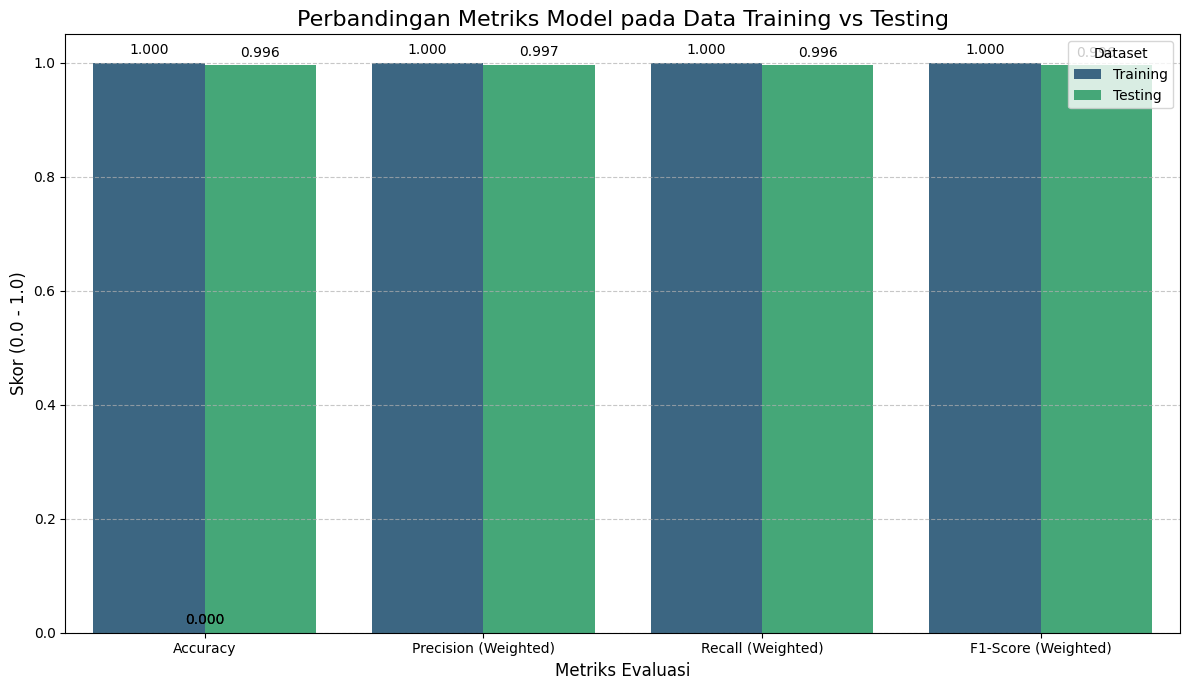

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

print("Mengevaluasi model terbaik (SVM RBF) pada data Training dan Testing...")

# --- 1. Evaluasi pada Data Training ---
y_pred_train = grid.predict(X_train_scaled)
acc_train = accuracy_score(y_train, y_pred_train)
report_train_dict = classification_report(y_train, y_pred_train, target_names=le.classes_, output_dict=True, zero_division=0)

train_metrics = report_train_dict['weighted avg']
train_precision = train_metrics['precision']
train_recall = train_metrics['recall']
train_f1 = train_metrics['f1-score']

print("\n--- Hasil pada Data Training ---")
print(f"Akurasi: {acc_train:.4f}")
print(f"Precision (Weighted): {train_precision:.4f}")
print(f"Recall (Weighted): {train_recall:.4f}")
print(f"F1-Score (Weighted): {train_f1:.4f}")

# --- 2. Evaluasi pada Data Testing ---
y_pred_test = grid.predict(X_test_scaled)
acc_test = accuracy_score(y_test, y_pred_test)
report_test_dict = classification_report(y_test, y_pred_test, target_names=le.classes_, output_dict=True, zero_division=0)

# Ambil metriks 'weighted avg'
test_metrics = report_test_dict['weighted avg']
test_precision = test_metrics['precision']
test_recall = test_metrics['recall']
test_f1 = test_metrics['f1-score']

print("\n--- Hasil pada Data Testing ---")
print(f"Akurasi: {acc_test:.4f}")
print(f"Precision (Weighted): {test_precision:.4f}")
print(f"Recall (Weighted): {test_recall:.4f}")
print(f"F1-Score (Weighted): {test_f1:.4f}")
print("\nLaporan Klasifikasi Lengkap (Testing):")
print(classification_report(y_test, y_pred_test, target_names=le.classes_, zero_division=0))


# 3. Sajikan Hasil Performa Menggunakan Grafik

data = {
    'Metriks': ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)'],
    'Training': [acc_train, train_precision, train_recall, train_f1],
    'Testing': [acc_test, test_precision, test_recall, test_f1]
}
metrics_df = pd.DataFrame(data)

metrics_df_melted = metrics_df.melt('Metriks', var_name='Dataset', value_name='Skor')

print("\n--- Ringkasan Performa ---")
display(metrics_df.set_index('Metriks'))

# Buat bar chart
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x='Metriks',
    y='Skor',
    hue='Dataset',
    data=metrics_df_melted,
    palette='viridis'
)

plt.title('Perbandingan Metriks Model pada Data Training vs Testing', fontsize=16)
plt.ylabel('Skor (0.0 - 1.0)', fontsize=12)
plt.xlabel('Metriks Evaluasi', fontsize=12)
plt.ylim(0, 1.05)
plt.legend(title='Dataset', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.3f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontsize=10
    )

plt.tight_layout()
plt.show()